In [2]:
import numpy as np
import xarray as xr
import time 
import os
from netCDF4 import Dataset
from pyproj import CRS
import rasterio
import rioxarray
from rasterio.enums import Resampling
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
#For calculating statistical northness and eastness

filename_physstates_2d = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jan_jun.nc'
physstates_2d = Dataset(filename_physstates_2d, 'r')
gridLons = physstates_2d.variables['gridLons']

In [23]:
#Time-average the bottom feature and create min, mean, max or similar features

def process_feature(filepath,
    variable_name,
    gridLons=None  # To calculate statistical northness and eastness
):
    """
    Process bottom layer data for a specified variable in a NetCDF file.

    Parameters:
    - filepath (str): Path to the NetCDF file from "combine_sinmod_years.ipynb".
                    The bottom data for a variable across all combined years
    - variable_name (str): Name of the variable to process.
    
    Returns:
    - xarray.DataArray: The time-averaged bottom layer data with features. 
    """
    time_start = time.time()

    ds = xr.open_dataset(filepath)
    print(f"\nAccessed the dataset after {time.time() - time_start:.2f} seconds")

    if variable_name == "temperature_sundahl":
        print("tmep sundahl")
        #bottom_layer_data = ds['temperature']
    else:
        bottom_layer_data = ds[variable_name]

    ds.close()

    print(f"\nExtracted the bottom layer data after {time.time() - time_start:.2f} seconds.\n\nStarting computation of statistics...")

    if variable_name == 'temperature_sundahl':
        march_may_indexes = []
        for year_start in [0, 365, 730]:
            march_may_indexes.extend(range(year_start + 59, year_start + 151))
        
        march_may_data = bottom_layer_data.isel(time=march_may_indexes)

        oct_dec_indexes = []
        for year_start in [0, 365, 730]:
            oct_dec_indexes.extend(range(year_start + 273, year_start + 365))
        
        oct_dec_data = bottom_layer_data.isel(time=oct_dec_indexes)

        #Compute seasonal means
        mean_march_may = march_may_data.mean(dim="time", skipna=True)
        mean_oct_dec = oct_dec_data.mean(dim="time", skipna=True)
    
        print(f"\nComputed statistics after {time.time() - time_start:.2f} seconds")
    
        stats_array = xr.concat([mean_march_may, mean_oct_dec], dim="stat").rename(f"{variable_name}_features")
        stats_array = stats_array.assign_coords(stat=["min_(mean_march_may)", "max_(mean_oct_dec)"])
    else:
        time_avg_bottom_layer = bottom_layer_data.mean(dim="time", skipna=True)

        time_percentiles = bottom_layer_data.quantile([0.1, 0.9], dim="time", skipna=True)

        print(f"\nComputed statistics after {time.time() - time_start:.2f} seconds")

        stats_array = xr.concat(
            [time_avg_bottom_layer, time_percentiles.sel(quantile=0.1).drop_vars("quantile"), 
             time_percentiles.sel(quantile=0.9).drop_vars("quantile")],
            dim="stat"
        ).rename(f"{variable_name}_features")
        stats_array = stats_array.assign_coords(stat=["mean", "10th_percentile", "90th_percentile"])

    return stats_array

In [4]:
#Run for desired features
temperature = process_feature('/cluster/home/maikents/sinmod_combine_years/temp_bottom_layer.nc', 'temperature')


Accessed the dataset after 0.12 seconds

Extracted the bottom layer data after 0.13 seconds.

Starting computation of statistics...


/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,



Computed statistics after 39.26 seconds


In [19]:
temperature.to_netcdf('/cluster/home/maikents/sinmod_features_masters/temperature.nc')

In [15]:
temperature_sundahl = process_feature('/cluster/home/maikents/sinmod_combine_years/temp_bottom_layer.nc', 'temperature_sundahl')


Accessed the dataset after 0.01 seconds

Extracted the bottom layer data after 0.01 seconds.

Starting computation of statistics...

Computed statistics after 2.07 seconds


In [20]:
temperature_sundahl.to_netcdf('/cluster/home/maikents/sinmod_features_masters/temperature_sundahl.nc')

In [25]:
salinity = process_feature('/cluster/home/maikents/sinmod_combine_years/salinity_bottom_layer.nc', 'salinity')


Accessed the dataset after 0.01 seconds

Extracted the bottom layer data after 0.01 seconds.

Starting computation of statistics...


/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,



Computed statistics after 38.20 seconds


In [32]:
salinity.to_netcdf('/cluster/home/maikents/sinmod_features_masters/salinity.nc')

In [33]:
current_speed = process_feature('/cluster/home/maikents/sinmod_combine_years/current_speed_bottom_layer.nc', 'current_speed')


Accessed the dataset after 0.01 seconds

Extracted the bottom layer data after 0.01 seconds.

Starting computation of statistics...


/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,



Computed statistics after 40.33 seconds


In [41]:
current_speed.to_netcdf('/cluster/home/maikents/sinmod_features_masters/current_speed.nc')

In [42]:
statistical_northness = process_feature('/cluster/home/maikents/sinmod_combine_years/statistical_northness_bottom_layer.nc', 'statistical_northness')


Accessed the dataset after 0.08 seconds

Extracted the bottom layer data after 0.08 seconds.

Starting computation of statistics...


/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,



Computed statistics after 50.80 seconds


In [46]:
statistical_northness.to_netcdf('/cluster/home/maikents/sinmod_features_masters/statistical_northness.nc')

In [47]:
statistical_eastness = process_feature('/cluster/home/maikents/sinmod_combine_years/statistical_eastness_bottom_layer.nc', 'statistical_eastness')


Accessed the dataset after 0.01 seconds

Extracted the bottom layer data after 0.01 seconds.

Starting computation of statistics...


/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,



Computed statistics after 42.09 seconds


In [51]:
statistical_eastness.to_netcdf('/cluster/home/maikents/sinmod_features_masters/statistical_eastness.nc')

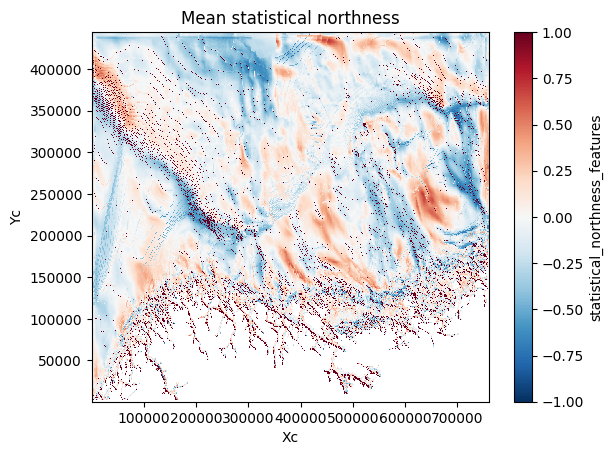

In [52]:
statistical_northness.sel(stat='mean').plot()
plt.title('Mean statistical northness')
plt.xlabel('Xc') 
plt.ylabel('Yc') 
plt.show()

In [53]:
mean_value = statistical_eastness.sel(stat='mean').mean(dim=['yc', 'xc'])
percentile_10_value = statistical_eastness.sel(stat='10th_percentile').mean(dim=['yc', 'xc'])
percentile_90_value = statistical_eastness.sel(stat='90th_percentile').mean(dim=['yc', 'xc'])


print(f"Mean value for 'mean' stat: {mean_value.values}")
print(f"Mean value for '10th_percentile' stat: {percentile_10_value.values}")
print(f"Mean value for '90th_percentile' stat: {percentile_90_value.values}")

Mean value for 'mean' stat: 0.05652881846046106
Mean value for '10th_percentile' stat: -0.7647485845607173
Mean value for '90th_percentile' stat: 0.8210949229018221


In [ ]:
#Align SINMOD and EMOD data into same format. Returns a big array of all the features including EMOD and SINMOD, 
#with the same grid spacing and EPRSG.

In [3]:
temperature = xr.open_dataset('/cluster/home/maikents/sinmod_features_masters/temperature.nc')
temperature_sundahl = xr.open_dataset('/cluster/home/maikents/sinmod_features_masters/temperature_sundahl.nc')
salinity = xr.open_dataset('/cluster/home/maikents/sinmod_features_masters/salinity.nc')
current_speed = xr.open_dataset('/cluster/home/maikents/sinmod_features_masters/current_speed.nc')
statistical_northness = xr.open_dataset('/cluster/home/maikents/sinmod_features_masters/statistical_northness.nc')
statistical_eastness = xr.open_dataset('/cluster/home/maikents/sinmod_features_masters/statistical_eastness.nc')

In [4]:
#1: Load and combine all bottom features 
SINMOD_features = xr.Dataset({
    'bottom_temperature_sundahl_features': temperature_sundahl['temperature_sundahl_features'],
    'bottom_temperature_features': temperature['temperature_features'],
    'bottom_salinity_features': salinity['salinity_features'],
    'bottom_current_features': current_speed['current_speed_features'],
    'bottom_statistical_northness_features': statistical_northness['statistical_northness_features'],
    'bottom_statistical_eastness_features': statistical_eastness['statistical_eastness_features'],
})

temperature.close()
temperature_sundahl.close()
salinity.close()
current_speed.close()
statistical_northness.close()
statistical_eastness.close()



SINMOD_features = SINMOD_features.reset_coords(drop=True)

print(SINMOD_features)

<xarray.Dataset> Size: 84MB
Dimensions:                                (xc: 950, yc: 555, stat: 5)
Coordinates:
  * xc                                     (xc) float32 4kB 800.0 ... 7.6e+05
  * yc                                     (yc) float32 2kB 800.0 ... 4.44e+05
  * stat                                   (stat) <U20 400B '10th_percentile'...
Data variables:
    bottom_temperature_sundahl_features    (stat, yc, xc) float32 11MB nan .....
    bottom_temperature_features            (stat, yc, xc) float32 11MB nan .....
    bottom_salinity_features               (stat, yc, xc) float32 11MB nan .....
    bottom_current_features                (stat, yc, xc) float32 11MB nan .....
    bottom_statistical_northness_features  (stat, yc, xc) float64 21MB nan .....
    bottom_statistical_eastness_features   (stat, yc, xc) float64 21MB nan .....


In [5]:
#3: Get the SINMOD crs and attach it to the dataset

def obtain_sinmod_crs(PhysStates_data):
    grid_mapping = PhysStates_data['grid_mapping']  #Replace 'grid_mapping' with the correct variable name if different
    grid_attrs = grid_mapping.attrs  

    #Print horizontal resolution if available
    horizontal_resolution = grid_attrs.get('horizontal_resolution', 'unknown')
    print(f"\nHorizontal resolution: {horizontal_resolution} meters")

    #Construct the CRS using the attributes
    crs_sinmod = CRS.from_proj4(
        f"+proj=stere "
        f"+lat_0={grid_attrs['latitude_of_projection_origin']} "
        f"+lat_ts={grid_attrs['standard_parallel']} "
        f"+lon_0={grid_attrs['straight_vertical_longitude_from_pole']} "
        f"+x_0={grid_attrs['false_easting']} "
        f"+y_0={grid_attrs['false_northing']} "
        f"+a={grid_attrs['semi_major_axis']} "
        f"+b={grid_attrs['semi_minor_axis']} "
        f"+units=m +no_defs"
    )

    print(f"\nSINMOD CRS: {crs_sinmod}")
    return crs_sinmod

filename_physstates_2019 = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc'
physstates_2019 = xr.open_dataset(filename_physstates_2019)

midnor_crs = obtain_sinmod_crs(physstates_2019 )

del(physstates_2019)

#Attach the crs to the SINMOD dataset
SINMOD_features = SINMOD_features.rio.write_crs(midnor_crs)


Horizontal resolution: 800.0 meters

SINMOD CRS: +proj=stere +lat_0=90.0 +lat_ts=60.0 +lon_0=58.0 +x_0=2544800.0 +y_0=1918800.0 +a=6370000.0 +b=6370000.0 +units=m +no_defs +type=crs


In [6]:
#4: Align the SINMOD data with the bathymetry

tif_file = '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif'

tif_files = ['/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/aspect_cos.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/aspect_sin.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/broad_BPI_std.tif',
             '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/fine_BPI_std.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/log_ruggedness_1.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/slope.tif']


def align_SINMOD_and_bathymetry(SINMOD_features, tif_file, resampling=Resampling.bilinear):
        
    with rioxarray.open_rasterio(tif_file) as tif:

        #Remove the band dimension from the tif data
        if 'band' in tif.dims:
            tif = tif.isel(band=0)

        SINMOD_features_reprojected = SINMOD_features.rio.reproject_match(tif, resampling=resampling)

        print(SINMOD_features_reprojected.rio.bounds())

        
        sinmod_mask = SINMOD_features_reprojected['bottom_salinity_features'][0].isnull()

        #Apply the mask to the EMOD data
        tif = tif.where(~sinmod_mask, np.nan)

        valid_mask = SINMOD_features_reprojected['bottom_salinity_features'][0].notnull()

        valid_columns = valid_mask.any(dim="y")  
        min_col = valid_columns.argmax().item()  #First non-NaN column from the left
        max_col = valid_columns.shape[0] - valid_columns[::-1].argmax().item() - 1  #First non-NaN column from the right

        #Find the first valid row (non-NaN) from the top (min row index)
        valid_rows = valid_mask.any(dim="x")  #Check for valid values in each row
        min_row = valid_rows.argmax().item()  #First non-NaN row from the top
        max_row = valid_rows.shape[0] - valid_rows[::-1].argmax().item() - 1  #Adjust for reverse indexing

        #Slice the raster to the bounding box of valid data
        clipped_SINMOD_features = SINMOD_features_reprojected.isel(x=slice(min_col, max_col + 1), y=slice(min_row, max_row + 1))
        
        clipped_tif = tif.rio.clip_box(minx=clipped_SINMOD_features.rio.bounds()[0]+1, 
                                        miny=clipped_SINMOD_features.rio.bounds()[1], 
                                        maxx=clipped_SINMOD_features.rio.bounds()[2], 
                                        maxy=clipped_SINMOD_features.rio.bounds()[3])
        
        clipped_tif = clipped_tif.reset_coords(drop=True)

    return clipped_SINMOD_features, clipped_tif

SINMOD_features_reprojected, tif = align_SINMOD_and_bathymetry(SINMOD_features, tif_file)

(-148857.58868623473, 6580002.847672726, 866884.4113137652, 7621679.847672726)


In [7]:
print(list(SINMOD_features_reprojected.variables))
print(type(SINMOD_features_reprojected))

['stat', 'spatial_ref', 'x', 'y', 'bottom_temperature_sundahl_features', 'bottom_temperature_features', 'bottom_salinity_features', 'bottom_current_features', 'bottom_statistical_northness_features', 'bottom_statistical_eastness_features']
<class 'xarray.core.dataset.Dataset'>


In [95]:
#5: Handle missing values in the SINMOD dataset, make sure NaNs are consistent throughout

#Check that all features have the same null points
assert (SINMOD_features_reprojected['bottom_temperature_features'].isnull() == 
    SINMOD_features_reprojected['bottom_salinity_features'].isnull()).all()
assert (SINMOD_features_reprojected['bottom_temperature_features'].isnull() == 
    SINMOD_features_reprojected['bottom_current_features'].isnull()).all()

#Check that if one is not null, then they are all not null
assert (SINMOD_features_reprojected['bottom_temperature_features'].notnull() == 
    SINMOD_features_reprojected['bottom_salinity_features'].notnull()).all()
assert (SINMOD_features_reprojected['bottom_temperature_features'].notnull() == 
    SINMOD_features_reprojected['bottom_current_features'].notnull()).all()

#Ensure that tif is NaN everywhere SINMOD_features_reprojected is NaN
assert np.all(np.isnan(tif.values) == np.isnan(SINMOD_features_reprojected['bottom_temperature_features'][0].values))

#Ensure that tif is non-Nan everywhere SINMOD_features_reprojected is non-NaN
assert np.all(np.isfinite(tif.values) == np.isfinite(SINMOD_features_reprojected['bottom_temperature_features'][0].values))

In [12]:
#7: Repeat for all the EMOD tifs and create a dataset for all the clipped tif files
tif_files = ['/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/aspect_cos.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/aspect_sin.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/broad_BPI_std.tif',
             '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/fine_BPI_std.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/log_ruggedness_1.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/slope.tif']

EMOD_features = xr.Dataset()

for file in tif_files:
    SINMOD_temp, file_tif = align_SINMOD_and_bathymetry(SINMOD_features, file)
    
    #Add the clipped tif as a new variable in the dataset
    file_name = file.split("/")[-1].split(".")[0] + "_clipped"
    var_name = file.split("/")[-1].split(".")[0]
    EMOD_features[var_name] = file_tif

    file_tif.to_netcdf(f'/cluster/home/maikents/features_midnor_2019/emod_features2/{file_name}.nc', mode='w')

    # Clear memory of file_tif and SINMOD_temp
    del file_tif
    del SINMOD_temp

EMOD_features = EMOD_features.reset_coords(drop=True)
EMOD_features.to_netcdf('/cluster/home/maikents/features_midnor_2019/emod_features2/EMOD_features2.nc', mode='w')

(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)
(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)
(-148857.58868623473, 6580002.847672726, 866884.4113137652, 7621679.847672726)
(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)
(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)
(-148857.58868623473, 6580002.847672726, 866884.4113137652, 7621679.847672726)
(-65592.58868623473, 6656715.847672726, 784256.4113137652, 7539233.847672726)


In [96]:
EMOD_features = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/emod_features2/EMOD_features2.nc')

In [97]:
print(list(EMOD_features.variables))

['x', 'y', 'aspect_cos', 'aspect_sin', 'bathymetry_32N_Clip_sample', 'broad_BPI_std', 'fine_BPI_std', 'log_ruggedness_1', 'slope']


In [98]:
for var in EMOD_features.data_vars:
    data_array = EMOD_features[var]
    
    num_nans = data_array.isnull().sum().values.item()  # Count NaNs
    
    num_non_nans = data_array.notnull().sum().values.item()  # Count non-NaNs
    
    print(f"{var} - NaNs: {num_nans}, Non-NaNs: {num_non_nans}")

aspect_cos - NaNs: 47132741, Non-NaNs: 33378334
aspect_sin - NaNs: 47132741, Non-NaNs: 33378334
bathymetry_32N_Clip_sample - NaNs: 46248444, Non-NaNs: 34262631
broad_BPI_std - NaNs: 46922976, Non-NaNs: 33588099
fine_BPI_std - NaNs: 46922976, Non-NaNs: 33588099
log_ruggedness_1 - NaNs: 46248444, Non-NaNs: 34262631
slope - NaNs: 47132741, Non-NaNs: 33378334


In [8]:
output_file = '/cluster/home/maikents/sinmod_features_masters/sinmod_bottom_features_emod_grid_no_current_aspect.nc'
SINMOD_features_reprojected.to_netcdf(output_file, mode='w')

In [9]:
#Current aspect angle from "combine_sinmod_years.ipynb"

current_aspect_angle = xr.open_dataset('/cluster/home/maikents/sinmod_features_masters/current_aspect_angle_emod_grid.nc')



In [ ]:
SINMOD_features_reprojected['current_aspect_angle'] = current_aspect_angle['current_aspect_angle']

In [84]:
print(SINMOD_features_reprojected)

<xarray.Dataset> Size: 14GB
Dimensions:                                (stat: 5, x: 8319, y: 9668)
Coordinates:
  * stat                                   (stat) <U20 400B '10th_percentile'...
  * x                                      (x) float64 67kB -6.546e+04 ... 6....
  * y                                      (y) float64 77kB 7.539e+06 ... 6.6...
Data variables:
    spatial_ref                            int64 8B ...
    bottom_temperature_sundahl_features    (stat, y, x) float32 2GB ...
    bottom_temperature_features            (stat, y, x) float32 2GB ...
    bottom_salinity_features               (stat, y, x) float32 2GB ...
    bottom_current_features                (stat, y, x) float32 2GB ...
    bottom_statistical_northness_features  (stat, y, x) float64 3GB ...
    bottom_statistical_eastness_features   (stat, y, x) float64 3GB ...
    current_aspect_angle                   (y, x) float64 643MB ...


In [85]:
#10: Saving the reprojected, unstandardized data
output_file = '/cluster/home/maikents/sinmod_features_masters/sinmod_bottom_features_emod_grid.nc'
SINMOD_features_reprojected.to_netcdf(output_file, mode='w')

In [3]:
sinmod_unstandardized = xr.open_dataset('/cluster/home/maikents/sinmod_features_masters/sinmod_bottom_features_emod_grid.nc')

In [4]:
print(list(sinmod_unstandardized.variables))

['stat', 'spatial_ref', 'x', 'y', 'bottom_temperature_sundahl_features', 'bottom_temperature_features', 'bottom_salinity_features', 'bottom_current_features', 'bottom_statistical_northness_features', 'bottom_statistical_eastness_features', 'current_aspect_angle']


In [5]:
nan_count = {}
non_nan_count = {}

for var in sinmod_unstandardized.variables:
    nan_count[var] = sinmod_unstandardized[var].isnull().sum().item()  # Count NaNs for each variable
    non_nan_count[var] = sinmod_unstandardized[var].notnull().sum().item()  # Count non-NaNs for each variable

# Print the results
for var in sinmod_unstandardized.variables:
    print(f"{var}: NaN count = {nan_count[var]}, Non-NaN count = {non_nan_count[var]}")

stat: NaN count = 0, Non-NaN count = 5
spatial_ref: NaN count = 0, Non-NaN count = 1
x: NaN count = 0, Non-NaN count = 8319
y: NaN count = 0, Non-NaN count = 9668
bottom_temperature_sundahl_features: NaN count = 334788986, Non-NaN count = 67351474
bottom_temperature_features: NaN count = 301113249, Non-NaN count = 101027211
bottom_salinity_features: NaN count = 301113249, Non-NaN count = 101027211
bottom_current_features: NaN count = 301113249, Non-NaN count = 101027211
bottom_statistical_northness_features: NaN count = 301113375, Non-NaN count = 101027085
bottom_statistical_eastness_features: NaN count = 301113375, Non-NaN count = 101027085
current_aspect_angle: NaN count = 47211531, Non-NaN count = 33216561


In [7]:
#Standardize temperature sundahl

temperature = sinmod_unstandardized.variables['bottom_temperature_sundahl_features'][:]

temp_data= temperature.astype(np.float32)  
temp_data_scaled = np.copy(temp_data)    

reshaped_temp_data = temp_data.values.reshape(temp_data.shape[0], -1)  

mask = np.isnan(reshaped_temp_data)

temp_scaler = StandardScaler()
for i in range(reshaped_temp_data.shape[1]):  
    column = reshaped_temp_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_temp_data[:, i][~mask[:, i]] = temp_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


temp_data_scaled = reshaped_temp_data.reshape(temp_data.shape)

temperature_standardized_sundahl = xr.DataArray(temp_data_scaled, dims=temperature.dims, attrs=temperature.attrs)

print(f"Standardised Temperature - Mean: {temperature_standardized_sundahl.mean():.2f}, Std Dev: {temperature_standardized_sundahl.std():.2f}")


Standardised Temperature - Mean: 0.00, Std Dev: 1.00


In [8]:
temperature_standardized_sundahl.to_netcdf('/cluster/home/maikents/sinmod_features_masters/standardized_features_emod_grid/standardized_temperature_sundahl.nc', mode='w')

In [ ]:
#Standardize temperature 

temperature = sinmod_unstandardized.variables['bottom_temperature_features'][:]

temp_data= temperature.astype(np.float32)  
temp_data_scaled = np.copy(temp_data)    

reshaped_temp_data = temp_data.values.reshape(temp_data.shape[0], -1)  

mask = np.isnan(reshaped_temp_data)

temp_scaler = StandardScaler()
for i in range(reshaped_temp_data.shape[1]):  
    column = reshaped_temp_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_temp_data[:, i][~mask[:, i]] = temp_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


temp_data_scaled = reshaped_temp_data.reshape(temp_data.shape)

temperature_standardized = xr.DataArray(temp_data_scaled, dims=temperature.dims, attrs=temperature.attrs)

print(f"Standardised Temperature - Mean: {temperature_standardized.mean():.2f}, Std Dev: {temperature_standardized.std():.2f}")


In [ ]:
temperature_standardized.to_netcdf('/cluster/home/maikents/sinmod_features_masters/standardized_features_emod_grid/standardized_temperature.nc', mode='w')

In [3]:
#Standardize salinity

salinity = sinmod_unstandardized.variables['bottom_salinity_features'][:]

sal_data= salinity.astype(np.float32)  
sal_data_scaled = np.copy(sal_data)    

reshaped_sal_data = sal_data.values.reshape(sal_data.shape[0], -1)  

mask = np.isnan(reshaped_sal_data)

sal_scaler = StandardScaler()
for i in range(reshaped_sal_data.shape[1]):  
    column = reshaped_sal_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_sal_data[:, i][~mask[:, i]] = sal_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


sal_data_scaled = reshaped_sal_data.reshape(sal_data.shape)

salinity_standardized = xr.DataArray(sal_data_scaled, dims=salinity.dims, attrs=salinity.attrs)

print(f"Standardised Salinity - Mean: {salinity_standardized.mean():.2f}, Std Dev: {salinity_standardized.std():.2f}")


Standardised Salinity - Mean: 0.00, Std Dev: 1.00


In [4]:
salinity_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_salinity.nc', mode='w')

In [5]:
#Standardize current speed

current = sinmod_unstandardized.variables['bottom_current_features'][:]

cur_data= current.astype(np.float32)  
cur_data_scaled = np.copy(cur_data)    

reshaped_cur_data = cur_data.values.reshape(cur_data.shape[0], -1)  

mask = np.isnan(reshaped_cur_data)

cur_scaler = StandardScaler()
for i in range(reshaped_cur_data.shape[1]):  
    column = reshaped_cur_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_cur_data[:, i][~mask[:, i]] = cur_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


cur_data_scaled = reshaped_cur_data.reshape(cur_data.shape)

current_standardized = xr.DataArray(cur_data_scaled, dims=current.dims, attrs=current.attrs)

print(f"Standardised Current Speed - Mean: {current_standardized.mean():.2f}, Std Dev: {current_standardized.std():.2f}")


Standardised Current Speed - Mean: -0.00, Std Dev: 1.00


In [6]:
current_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_current_speed.nc', mode='w')

In [7]:
#Standardize statistical northness

north = sinmod_unstandardized.variables['bottom_statistical_northness_features'][:]

north_data= north.astype(np.float32)  
north_data_scaled = np.copy(north_data)    

reshaped_north_data = north_data.values.reshape(north_data.shape[0], -1)  

mask = np.isnan(reshaped_north_data)

north_scaler = StandardScaler()
for i in range(reshaped_north_data.shape[1]):  
    column = reshaped_north_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_north_data[:, i][~mask[:, i]] = north_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


north_data_scaled = reshaped_north_data.reshape(north_data.shape)

north_standardized = xr.DataArray(north_data_scaled, dims=north.dims, attrs=north.attrs)

print(f"Standardised Statistical Northness - Mean: {north_standardized.mean():.2f}, Std Dev: {north_standardized.std():.2f}")


Standardised Statistical Northness - Mean: -0.00, Std Dev: 1.00


In [8]:
north_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_statistical_northness.nc', mode='w')

In [9]:
#Standardize statistical eastness

east = sinmod_unstandardized.variables['bottom_statistical_eastness_features'][:]

east_data= east.astype(np.float32)  
east_data_scaled = np.copy(east_data)    

reshaped_east_data = east_data.values.reshape(east_data.shape[0], -1)  

mask = np.isnan(reshaped_east_data)

east_scaler = StandardScaler()
for i in range(reshaped_east_data.shape[1]):  
    column = reshaped_east_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_east_data[:, i][~mask[:, i]] = east_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


east_data_scaled = reshaped_east_data.reshape(east_data.shape)

east_standardized = xr.DataArray(east_data_scaled, dims=east.dims, attrs=east.attrs)

print(f"Standardised Statistical Eastness - Mean: {east_standardized.mean():.2f}, Std Dev: {east_standardized.std():.2f}")


Standardised Statistical Eastness - Mean: -0.00, Std Dev: 1.00


In [10]:
east_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_statistical_eastness.nc', mode='w')

In [5]:
current_aspect_angle = sinmod_unstandardized.variables['current_aspect_angle']

In [6]:
#Standardize current aspect angle

ang = current_aspect_angle[:]

ang_data= ang.astype(np.float32)  
ang_data_scaled = np.copy(ang_data)    

reshaped_ang_data = ang_data.values.reshape(ang_data.shape[0], -1)  

mask = np.isnan(reshaped_ang_data)

ang_scaler = StandardScaler()
for i in range(reshaped_ang_data.shape[1]):  
    column = reshaped_ang_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_ang_data[:, i][~mask[:, i]] = ang_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


ang_data_scaled = reshaped_ang_data.reshape(ang_data.shape)

ang_standardized = xr.DataArray(ang_data_scaled, dims=ang.dims, attrs=ang.attrs)

print(f"Standardised Current Aspect Angle - Mean: {ang_standardized.mean():.2f}, Std Dev: {ang_standardized.std():.2f}")

Standardised Current Aspect Angle - Mean: 0.00, Std Dev: 1.00


In [7]:
ang_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_current_aspect_angle.nc', mode='w')

In [12]:
#Combine standardized features
sinmod_unstandardized = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/SINMOD_bottom_features_emod_grid2.nc')
salinity = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_salinity.nc')
temperature = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_sundahl_temperature.nc')
current = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_current_speed.nc')
statistical_northness = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_statistical_northness.nc')
statistical_eastness = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_statistical_eastness.nc')
current_aspect_angle = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_current_aspect_angle.nc')

In [13]:
sinmod_standardized = sinmod_unstandardized.copy()

sinmod_standardized['bottom_temperature_sundahl_features'] = temperature['__xarray_dataarray_variable__']
sinmod_standardized['bottom_salinity_features'] = salinity['__xarray_dataarray_variable__']
sinmod_standardized['bottom_current_features'] = current['__xarray_dataarray_variable__']
sinmod_standardized['bottom_statistical_northness_features'] = statistical_northness['__xarray_dataarray_variable__']
sinmod_standardized['bottom_statistical_eastness_features'] = statistical_eastness['__xarray_dataarray_variable__']
sinmod_standardized['current_aspect_angle'] = current_aspect_angle['__xarray_dataarray_variable__']

#saving it
sinmod_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/SINMOD_bottom_features_emod_grid_standardized2.nc')

In [14]:
nan_count = {}
non_nan_count = {}

for var in sinmod_standardized.variables:
    nan_count[var] = sinmod_standardized[var].isnull().sum().item()  # Count NaNs for each variable
    non_nan_count[var] = sinmod_standardized[var].notnull().sum().item()  # Count non-NaNs for each variable

# Print the results
for var in sinmod_standardized.variables:
    print(f"{var}: NaN count = {nan_count[var]}, Non-NaN count = {non_nan_count[var]}")

stat: NaN count = 0, Non-NaN count = 5
x: NaN count = 0, Non-NaN count = 11162
y: NaN count = 0, Non-NaN count = 11447
spatial_ref: NaN count = 0, Non-NaN count = 1
bottom_temperature_sundahl_features: NaN count = 570331808, Non-NaN count = 68525262
bottom_salinity_features: NaN count = 536069177, Non-NaN count = 102787893
bottom_current_features: NaN count = 536069177, Non-NaN count = 102787893
bottom_statistical_northness_features: NaN count = 536069303, Non-NaN count = 102787767
bottom_statistical_eastness_features: NaN count = 536069303, Non-NaN count = 102787767
current_aspect_angle: NaN count = 94395413, Non-NaN count = 33376001


In [35]:
emod_data = xr.open_dataset("/cluster/home/maikents/features_midnor_2019/emod_features2/EMOD_features2.nc")


In [16]:
print(list(emod_data.variables))

['x', 'y', 'aspect_cos', 'aspect_sin', 'bathymetry_32N_Clip_sample', 'broad_BPI_std', 'fine_BPI_std', 'log_ruggedness_1', 'slope']


In [17]:
emod_unstandardized = emod_data.copy()

In [18]:
#Standardize aspect cos

aspect_cos = emod_unstandardized.variables['aspect_cos'][:]

aspect_cos_data= aspect_cos.astype(np.float32)  
aspect_cos_data_scaled = np.copy(aspect_cos_data)    

reshaped_aspect_cos_data = aspect_cos_data.values.reshape(aspect_cos_data.shape[0], -1)  

mask = np.isnan(reshaped_aspect_cos_data)

aspect_cos_scaler = StandardScaler()
for i in range(reshaped_aspect_cos_data.shape[1]):  
    column = reshaped_aspect_cos_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_aspect_cos_data[:, i][~mask[:, i]] = aspect_cos_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


aspect_cos_data_scaled = reshaped_aspect_cos_data.reshape(aspect_cos_data.shape)

aspect_cos_standardized = xr.DataArray(aspect_cos_data_scaled, dims=aspect_cos.dims, attrs=aspect_cos.attrs)

print(f"Standardised Aspect Cos - Mean: {aspect_cos_standardized.mean():.2f}, Std Dev: {aspect_cos_standardized.std():.2f}")


Standardised Aspect Cos - Mean: -0.00, Std Dev: 1.00


In [19]:
aspect_cos_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_aspect_cos.nc', mode='w')

In [20]:
#Standardize aspect sin

aspect_sin = emod_unstandardized.variables['aspect_sin'][:]

aspect_sin_data= aspect_sin.astype(np.float32)  
aspect_sin_data_scaled = np.copy(aspect_sin_data)    

reshaped_aspect_sin_data = aspect_sin_data.values.reshape(aspect_sin_data.shape[0], -1)  

mask = np.isnan(reshaped_aspect_sin_data)

aspect_sin_scaler = StandardScaler()
for i in range(reshaped_aspect_sin_data.shape[1]):  
    column = reshaped_aspect_sin_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_aspect_sin_data[:, i][~mask[:, i]] = aspect_sin_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


aspect_sin_data_scaled = reshaped_aspect_sin_data.reshape(aspect_sin_data.shape)

aspect_sin_standardized = xr.DataArray(aspect_sin_data_scaled, dims=aspect_sin.dims, attrs=aspect_sin.attrs)

print(f"Standardised Aspect Sin - Mean: {aspect_sin_standardized.mean():.2f}, Std Dev: {aspect_sin_standardized.std():.2f}")


Standardised Aspect Sin - Mean: 0.00, Std Dev: 1.00


In [21]:
aspect_sin_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_aspect_sin.nc', mode='w')

In [22]:
#Standardize bathymetry

bathymetry = emod_unstandardized.variables['bathymetry_32N_Clip_sample'][:]

bathymetry_data= bathymetry.astype(np.float32)  
bathymetry_data_scaled = np.copy(bathymetry_data)    

reshaped_bathymetry_data = bathymetry_data.values.reshape(bathymetry_data.shape[0], -1)  

mask = np.isnan(reshaped_bathymetry_data)

bathymetry_scaler = StandardScaler()
for i in range(reshaped_bathymetry_data.shape[1]):  
    column = reshaped_bathymetry_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_bathymetry_data[:, i][~mask[:, i]] = bathymetry_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


bathymetry_data_scaled = reshaped_bathymetry_data.reshape(bathymetry_data.shape)

bathymetry_standardized = xr.DataArray(bathymetry_data_scaled, dims=bathymetry.dims, attrs=bathymetry.attrs)

print(f"Standardised Bathymetry - Mean: {bathymetry_standardized.mean():.2f}, Std Dev: {bathymetry_standardized.std():.2f}")


Standardised Bathymetry - Mean: -0.00, Std Dev: 1.00


In [23]:
bathymetry_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_bathymetry.nc', mode='w')

In [24]:
#Standardize Broad BPI

broad_BPI = emod_unstandardized.variables['broad_BPI_std'][:]

broad_BPI_data= broad_BPI.astype(np.float32)  
broad_BPI_data_scaled = np.copy(broad_BPI_data)    

reshaped_broad_BPI_data = broad_BPI_data.values.reshape(broad_BPI_data.shape[0], -1)  

mask = np.isnan(reshaped_broad_BPI_data)

broad_BPI_scaler = StandardScaler()
for i in range(reshaped_broad_BPI_data.shape[1]):  
    column = reshaped_broad_BPI_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_broad_BPI_data[:, i][~mask[:, i]] = broad_BPI_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


broad_BPI_data_scaled = reshaped_broad_BPI_data.reshape(broad_BPI_data.shape)

broad_BPI_standardized = xr.DataArray(broad_BPI_data_scaled, dims=broad_BPI.dims, attrs=broad_BPI.attrs)

print(f"Standardised Broad BPI - Mean: {broad_BPI_standardized.mean():.2f}, Std Dev: {broad_BPI_standardized.std():.2f}")


Standardised Broad BPI - Mean: 0.00, Std Dev: 1.00


In [25]:
broad_BPI_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_broad_BPI.nc', mode='w')

In [26]:
#Standardize Fine BPI

fine_BPI = emod_unstandardized.variables['fine_BPI_std'][:]

fine_BPI_data= fine_BPI.astype(np.float32)  
fine_BPI_data_scaled = np.copy(fine_BPI_data)    

reshaped_fine_BPI_data = fine_BPI_data.values.reshape(fine_BPI_data.shape[0], -1)  

mask = np.isnan(reshaped_fine_BPI_data)

fine_BPI_scaler = StandardScaler()
for i in range(reshaped_fine_BPI_data.shape[1]):  
    column = reshaped_fine_BPI_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_fine_BPI_data[:, i][~mask[:, i]] = fine_BPI_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


fine_BPI_data_scaled = reshaped_fine_BPI_data.reshape(fine_BPI_data.shape)

fine_BPI_standardized = xr.DataArray(fine_BPI_data_scaled, dims=fine_BPI.dims, attrs=fine_BPI.attrs)

print(f"Standardised Fine BPI - Mean: {fine_BPI_standardized.mean():.2f}, Std Dev: {fine_BPI_standardized.std():.2f}")


Standardised Fine BPI - Mean: -0.00, Std Dev: 1.00


In [27]:
fine_BPI_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_fine_BPI.nc', mode='w')

In [28]:
#Standardize Log Ruggedness

log_ruggedness = emod_unstandardized.variables['log_ruggedness_1'][:]

log_ruggedness_data= log_ruggedness.astype(np.float32)  
log_ruggedness_data_scaled = np.copy(log_ruggedness_data)    

reshaped_log_ruggedness_data = log_ruggedness_data.values.reshape(log_ruggedness_data.shape[0], -1)  

mask = np.isnan(reshaped_log_ruggedness_data)

log_ruggedness_scaler = StandardScaler()
for i in range(reshaped_log_ruggedness_data.shape[1]):  
    column = reshaped_log_ruggedness_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_log_ruggedness_data[:, i][~mask[:, i]] = log_ruggedness_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


log_ruggedness_data_scaled = reshaped_log_ruggedness_data.reshape(log_ruggedness_data.shape)

log_ruggedness_standardized = xr.DataArray(log_ruggedness_data_scaled, dims=log_ruggedness.dims, attrs=log_ruggedness.attrs)

print(f"Standardised Log Ruggedness - Mean: {log_ruggedness_standardized.mean():.2f}, Std Dev: {log_ruggedness_standardized.std():.2f}")


Standardised Log Ruggedness - Mean: -0.00, Std Dev: 1.00


In [29]:
log_ruggedness_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_log_ruggedness.nc', mode='w')

In [30]:
#Standardize slope

slope = emod_unstandardized.variables['slope'][:]

slope_data= slope.astype(np.float32)  
slope_data_scaled = np.copy(slope_data)    

reshaped_slope_data = slope_data.values.reshape(slope_data.shape[0], -1)  

mask = np.isnan(reshaped_slope_data)

slope_scaler = StandardScaler()
for i in range(reshaped_slope_data.shape[1]):  
    column = reshaped_slope_data[:, i] 
    if not np.all(np.isnan(column)):  
        reshaped_slope_data[:, i][~mask[:, i]] = slope_scaler.fit_transform(column[~mask[:, i]].reshape(-1, 1)).ravel()


slope_data_scaled = reshaped_slope_data.reshape(slope_data.shape)

slope_standardized = xr.DataArray(slope_data_scaled, dims=slope.dims, attrs=slope.attrs)

print(f"Standardised Slope - Mean: {slope_standardized.mean():.2f}, Std Dev: {slope_standardized.std():.2f}")


Standardised Slope - Mean: 0.00, Std Dev: 1.00


In [31]:
slope_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_slope.nc', mode='w')

In [32]:
aspect_cos_standardized = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_aspect_cos.nc')
aspect_sin_standardized = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_aspect_sin.nc')
bathymetry_standardized = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_bathymetry.nc')
broad_BPI_standardized = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_broad_BPI.nc')
fine_BPI_standardized = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_fine_BPI.nc')
log_ruggedness_standardized = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_log_ruggedness.nc')
slope_standardized = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/standardized_single_features/standardized_slope.nc')


In [33]:
emod_standardized = emod_unstandardized.copy()

emod_standardized['aspect_cos'] = aspect_cos_standardized['__xarray_dataarray_variable__']
emod_standardized['aspect_sin'] = aspect_sin_standardized['__xarray_dataarray_variable__']
emod_standardized['bathymetry_32N_Clip_sample'] = bathymetry_standardized['__xarray_dataarray_variable__']
emod_standardized['broad_BPI_std'] = broad_BPI_standardized['__xarray_dataarray_variable__']
emod_standardized['fine_BPI_std'] = fine_BPI_standardized['__xarray_dataarray_variable__']
emod_standardized['log_ruggedness_1'] = log_ruggedness_standardized['__xarray_dataarray_variable__']
emod_standardized['slope'] = slope_standardized['__xarray_dataarray_variable__']

#saving it
emod_standardized.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/EMOD_standardized2.nc')